In [1]:
import numpy as np
from nwsspc.sharp.calc import parcel, thermo
import warnings 
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

In [2]:
#Most of this code is from SHARPpy (uwyo_decoder.py), but removed the date, lat/lon, and profile creation
stid='KOAX'
file_data = open(f'{stid}.html','r').read()
snfile = [l for l in file_data.split('\n')]
bgn = -1
end = -1
ttl = -1
stl = -1


for i in range(len(snfile)):
    if snfile[i] == "<PRE>": 
        bgn = i+5
    if snfile[i][:10] == "</PRE><H3>": 
        end = i-1
    if snfile[i][:4] == "<H2>" and snfile[i][-5:] == "</H2>": 
        ttl = i
    if 'Station latitude' in snfile[i]:
        stl = i
snd_data = []
for i in range(bgn, end+1):
    vals = []
    for j in [ 0, 1, 2, 3, 5, 6, 7, 8, 9 ]:
        val = snfile[i][(7 * j):(7 * (j + 1))].strip()


        if val == "":
            #vals.append(-9999)
            vals.append(np.nan)
        else:
            vals.append(float(val))
    snd_data.append(vals)
col_names = ['pres', 'hght', 'tmpc', 'dwpc', 'mixr', 'wdir', 'wspd', 'theta', 'thetae']
snd_dict = dict((v, np.array(p).astype('f')) for v, p in zip(col_names, list(zip(*snd_data))))
#'''
ni=[]
for idx, i in enumerate(snd_dict['tmpc']):
    if np.isnan(snd_dict['tmpc'][idx]): #or np.isnan(snd_dict['hght'][idx]) or np.isnan(snd_dict['tmpc'][idx]) or np.isnan(snd_dict['dwpc'][idx]) or np.isnan(snd_dict['wdir'][idx]) or np.isnan(snd_dict['wspd'][idx]):
        ni.append(idx)
for i in col_names:
    snd_dict[i]=np.delete(snd_dict[i],ni)
#'''
snd=snd_dict


#Noticed SounderPy was returning different CAPE values than SHARPpy and this is why:
idx=np.where(snd['pres']>=100)
for i in snd.keys():
    snd[i]=snd[i][idx]

## SHARPlib

In [3]:
snd['press']=snd['pres']*100
snd['tmpk']=snd['tmpc']+273.15
snd['dwpk']=snd['dwpc']+273.15
snd['mixr']=snd['mixr']/1000
vtmp = thermo.virtual_temperature(snd['tmpk'], snd['mixr'])
sfcpcl = parcel.Parcel()
parcel.define_parcel(snd['press'], snd['tmpk'], snd['dwpk'], snd['mixr'], snd['theta'], snd['thetae'], sfcpcl, parcel.LPL_SFC)
b=parcel.lift_parcel(parcel.lifter_wobus(), snd['press'], vtmp, sfcpcl)
parcel.cape_cinh(snd['press'], snd['hght'], b, sfcpcl)

[4318.8740234375, -30.851276397705078]

## METpy

In [4]:
import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as mpconsts

In [10]:
p = snd['pres'] * units.hPa
z = snd['hght'] * units.m
T = snd['tmpc'] * units.degC
Td = snd['dwpc'] * units.degC
mpcalc.surface_based_cape_cin(p, T, Td)

(<Quantity(3990.45178, 'joule / kilogram')>,
 <Quantity(-34.352474, 'joule / kilogram')>)

## SHARPpy

In [6]:
from sharppy.sharptab import profile, params
from sharppy.io.uwyo_decoder import UWYODecoder
from datetime import datetime

In [7]:
dates=datetime(2022, 4, 29, 21, 0)
prof = profile.create_profile(pres=snd['pres'], hght=snd['hght'], tmpc=snd['tmpc'], dwpc=snd['dwpc'], wspd=snd['wspd'], \
                              wdir=snd['wdir'], strictQC=False, profile='convective', date=dates)
prof.sfcpcl.bplus, prof.sfcpcl.bminus

(4298.063311636873, -30.697504238035435)

# SPC Sounding

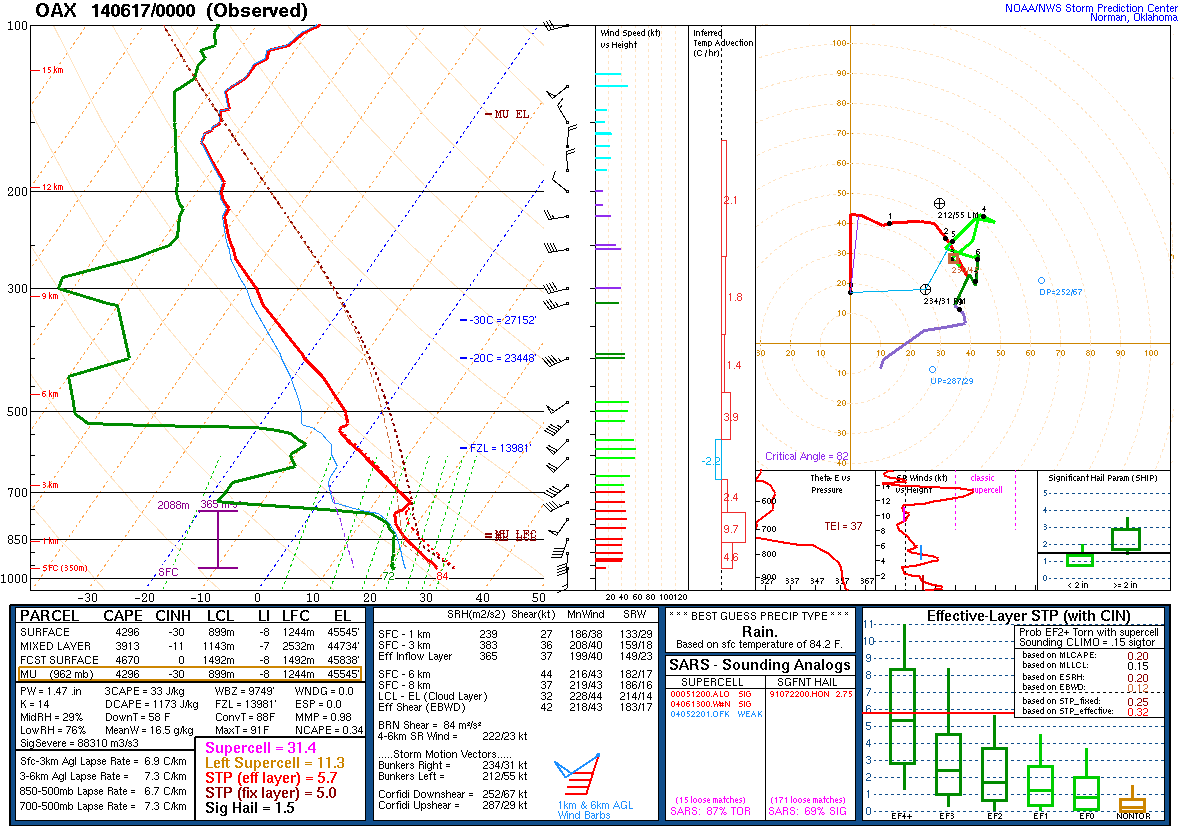

In [8]:
from IPython.display import Image
Image(filename=f'{stid}.png') 